# Figure 1 (a)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from py_vollib.black_scholes import black_scholes
from sklearn.metrics import mean_squared_error
import scipy.optimize as optimize
import random
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.ticker as ticker


#Heston
gamma = 0.5751
kappa = 1.5768
vbar  = 0.0484
rho   = -0.7
v0    = 0.1024

# Backbone Y
gamma_Y = 0.5751
kappa_Y = 1
vbar_Y  = 0.0144
v0_Y    = 0.0144



#****
r=0
S_0=1
sigma=0.3

#****
L=40
M=500
Lambda=0.00001
i = np.complex(0.0,1.0)

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [2]:
def GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S_0): 
    np.random.seed(111)
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])   
    
    X[:,0] = np.log(S_0)      
    dt = T / float(NoOfSteps)
    
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])           
        X[:,i+1] = X[:,i] + (r - 0.5 * sigma **2 ) * dt + sigma * np.power(dt, 0.5)*Z[:,i] 
    S = np.exp(X)  
    paths = {"S":S}
    return paths


def GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0): 
    np.random.seed(111)
    Z1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    Z2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    W1 = np.zeros([NoOfPaths, NoOfSteps+1])
    W2 = np.zeros([NoOfPaths, NoOfSteps+1])
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    X = np.zeros([NoOfPaths, NoOfSteps+1])
    V[:,0]=v0
    X[:,0]=np.log(S_0)
    
        
    dt = T / float(NoOfSteps)
    for i in range(0,NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:,i] = (Z1[:,i] - np.mean(Z1[:,i])) / np.std(Z1[:,i])
            Z2[:,i] = (Z2[:,i] - np.mean(Z2[:,i])) / np.std(Z2[:,i])
        Z2[:,i] = rho * Z1[:,i] + np.sqrt(1.0-rho**2)*Z2[:,i]
        
        W1[:,i+1] = W1[:,i] + np.power(dt, 0.5)*Z1[:,i]
        W2[:,i+1] = W2[:,i] + np.power(dt, 0.5)*Z2[:,i]
        
        # Truncated boundary condition
        V[:,i+1] = V[:,i] + kappa*(vbar - V[:,i]) * dt + gamma* np.sqrt(V[:,i]) * (W1[:,i+1]-W1[:,i])
        V[:,i+1] = np.maximum(V[:,i+1],0.0)
        
        X[:,i+1] = X[:,i] + (r - 0.5*V[:,i])*dt + np.sqrt(V[:,i])*(W2[:,i+1]-W2[:,i])

        
    #Compute exponent
    S = np.exp(X)
    paths = {"S":S}
    return paths


def BS_Call_Option_Price(CP,K,S_0,sigma,T,r):
    # if K is list:
    #     K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0))* T) / (sigma * np.sqrt(T))
    d2    = d1 - sigma * np.sqrt(T)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * T)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * T) - st.norm.cdf(-d1)*S_0
    return value

def ImpliedVolatility(marketPrice,K,CP,T,r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse

    sigmaGrid = np.linspace(0,2,200)
    optPriceGrid = np.zeros_like(sigmaGrid)
    for i, sigma in enumerate(sigmaGrid):
        optPriceGrid[i] = BS_Call_Option_Price(CP, K, S_0, sigma, T, r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    # print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price(CP,K,S_0,sigma,T,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    # print("Final volatility = {0}".format(impliedVol))
    return impliedVol



def BS_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,sigma,S_0,K):
    Paths_BS = GeneratePathsGBMABM(NoOfPaths,NoOfSteps,T,r,sigma,S_0)
    S = Paths_BS["S"]
    if CP=="c":
        return np.mean(np.maximum(S[:,-1]-K,0))
    if CP=="p":
        return np.mean(np.maximum(K-S[:,-1],0))



def Heston_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0,K):
    Paths = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S=Paths["S"]
    if CP=="c":
        return np.mean(np.maximum(S[:,-1]-K,0))
    if CP=="p":
        return np.mean(np.maximum(K-S[:,-1],0))
    
    


0.119235384740485
0.11945935913115527
0.0979625420623615
Implied volatility for CallPrice= 0.11945935913115527, strike K=1, 
      maturity T= 1, interest rate r= 0 and initial stock S_0=1 
      equals to sigma_imp = 0.3005678, using market price BS Euler discretization with nbre of paths =50000
      
Check : Option Price for implied volatility of 0.3005677842791911 is equal to 0.11945935913115524


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide 

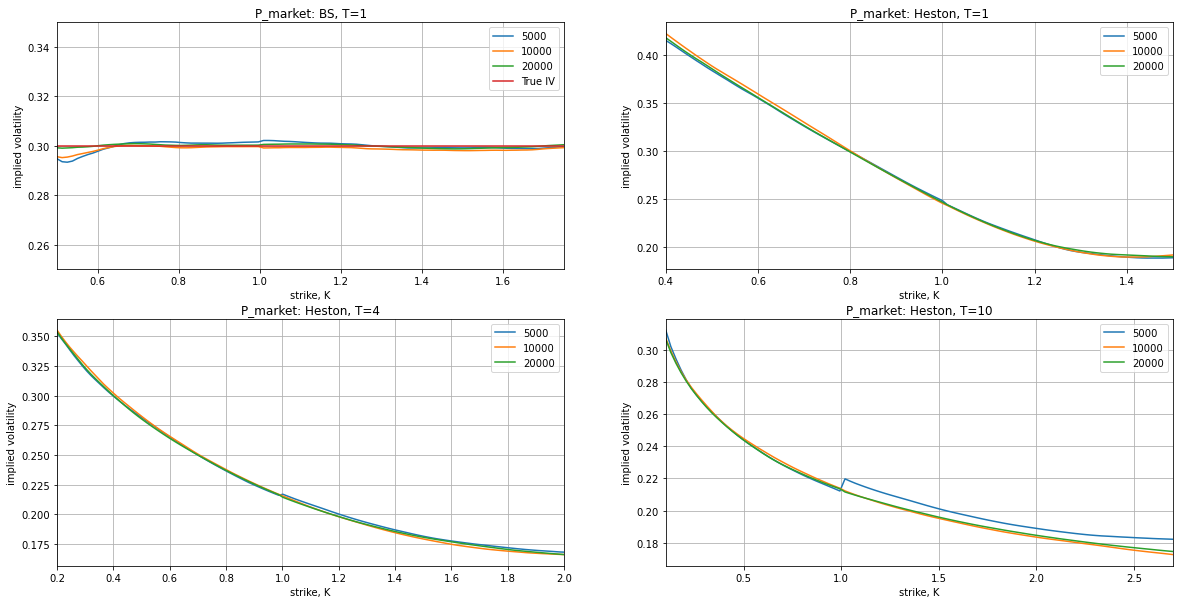

In [16]:
def mainCalculation(): 
    plt.figure(figsize=(20,10))
    
    
    NoOfPaths = 50000
    NoOfSteps = 1000
       
    T = 1
    K = 1
    CP ="c"
    
    
    V_market_BS=BS_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,sigma,S_0,K)
    
    P_Exact_BS=BS_Call_Option_Price(CP,K,S_0,sigma,T,r)
    
    V_market_H=Heston_paths_pricing(CP,NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0,K)
    
    print(P_Exact_BS)
    print(V_market_BS)
    print(V_market_H)
                
    sigma_imp = ImpliedVolatility(V_market_BS,K,CP,T,r)
    message = '''Implied volatility for CallPrice= {}, strike K={}, 
      maturity T= {}, interest rate r= {} and initial stock S_0={} 
      equals to sigma_imp = {:.7f}, using market price BS Euler discretization with nbre of paths ={}
      '''.format(V_market_BS,K,T,r,S_0,sigma_imp,NoOfPaths)
    
    print(message)

# Check! 
          
    val = BS_Call_Option_Price(CP,K,S_0,sigma_imp,T,r)
    print('Check : Option Price for implied volatility of {0} is equal to {1}'.format(sigma_imp, val))
    

    
    NoOfPaths1 = [5*10**3,10**4,2*10**4]
    
    
    
    
    plt.subplot(2, 2, 1)
    K1 = np.linspace(0.5,1.76,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.5,1.75)) 
    plt.ylim((0.25,0.35))
    plt.title("P_market: BS, T=1")
    legend = []
    for j in NoOfPaths1:
        
        Paths = GeneratePathsGBMABM(j,NoOfSteps,1,r,sigma,S_0)
        S1 = Paths["S"]
        L =np.zeros([len(K1),1])
  
        for idx in range(0,len(K1)):
            if K1[idx]> S_0:
                CP="c"
                V_market_BS1=np.mean(np.maximum(S1[:,-1]-K1[idx],0))
                L[idx] = ImpliedVolatility(V_market_BS1,K1[idx],CP,1,r)
            else:
                CP="p"
                V_market_BS1=np.mean(np.maximum(K1[idx]-S1[:,-1],0))
                L[idx] = ImpliedVolatility(V_market_BS1,K1[idx],CP,1,r)
        
        plt.plot(K1,L)
        legend.append('{0}'.format(j))
    
    L =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]> S_0:
            CP="c"
            V_market_BS1 = BS_Call_Option_Price(CP,K1[idx],S_0,sigma,1,r)
            L[idx] = ImpliedVolatility(V_market_BS1,K1[idx],CP,1,r)
        else:
            CP="p"
            V_market_BS1 = BS_Call_Option_Price(CP,K1[idx],S_0,sigma,1,r)
            L[idx] = ImpliedVolatility(V_market_BS1,K1[idx],CP,1,r)
        
    plt.plot(K1,L)
    legend.append('{0}'.format("True IV"))

    plt.legend(legend)
    


    
    plt.subplot(2, 2, 2)
    K2 = np.linspace(0.4,1.5,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.title("P_market: Heston, T=1")
    plt.xlim((0.4,1.5)) 
#     plt.ylim((0.01,0.45)) 
    legend = []
    for j in NoOfPaths1:
        
        Paths_H = GeneratePathsHestonEuler(j,NoOfSteps,1,r,S_0,kappa,gamma,rho,vbar,v0)
        S1_H = Paths_H["S"]
        L_H =np.zeros([len(K2),1])
  
        for idx in range(0,len(K2)):
            if K2[idx]> S_0:
                CP="c"
                V_market_H1=np.mean(np.maximum(S1_H[:,-1]-K2[idx],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K2[idx],CP,1,r)
            else:
                CP="p"
                V_market_H1=np.mean(np.maximum(K2[idx]-S1_H[:,-1],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K2[idx],CP,1,r)
        
        plt.plot(K2,L_H)
        legend.append('{0}'.format(j))

    plt.legend(legend)
    
    
    
    
    
    
    
    plt.subplot(2, 2, 3)
    K3 = np.linspace(0.2,2,120)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.title("P_market: Heston, T=4")
    plt.xlim((0.2,2)) 
#     plt.ylim((0.01,0.45)) 
    legend = []
    for j in NoOfPaths1:
        
        Paths_H = GeneratePathsHestonEuler(j,NoOfSteps,4,r,S_0,kappa,gamma,rho,vbar,v0)
        S1_H = Paths_H["S"]
        L_H =np.zeros([len(K3),1])
  
        for idx in range(0,len(K3)):
            if K3[idx]> S_0:
                CP="c"
                V_market_H1=np.mean(np.maximum(S1_H[:,-1]-K3[idx],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K3[idx],CP,4,r)
            else:
                CP="p"
                V_market_H1=np.mean(np.maximum(K3[idx]-S1_H[:,-1],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K3[idx],CP,4,r)
        
        plt.plot(K3,L_H)
        legend.append('{0}'.format(j))

    plt.legend(legend)
    
    
    
    
    
    
    
    plt.subplot(2, 2, 4)
    K4 = np.linspace(0.1,2.7,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.title("P_market: Heston, T=10")
    plt.xlim((0.1,2.7)) 
#    plt.ylim((0.01,0.45)) 
    legend = []
    for j in NoOfPaths1:
        
        Paths_H = GeneratePathsHestonEuler(j,NoOfSteps,10,r,S_0,kappa,gamma,rho,vbar,v0)
        S1_H = Paths_H["S"]
        L_H =np.zeros([len(K4),1])
  
        for idx in range(0,len(K4)):
            if K4[idx]> S_0:
                CP="c"
                V_market_H1=np.mean(np.maximum(S1_H[:,-1]-K4[idx],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K4[idx],CP,10,r)
            else:
                CP="p"
                V_market_H1=np.mean(np.maximum(K4[idx]-S1_H[:,-1],0))
                L_H[idx] = ImpliedVolatility(V_market_H1,K4[idx],CP,10,r)
        
        plt.plot(K4,L_H)
        legend.append('{0}'.format(j))

    plt.legend(legend)
    
    
    
    plt.show()
    
    
    
    
    
    
mainCalculation();

### Fonction de calcul de l'espérance conditionnelle

In [3]:
def Expectation(NoOfPaths,Lambda,Lg,Z,S,V):

    kernel = lambda X1, X2: np.exp(-5 * np.linalg.norm(X1 - X2)**2)

    K = np.zeros((NoOfPaths,Lg))
    for i in range(NoOfPaths):
        for j in range(Lg):
            K[i, j] = kernel(Z[j], S[i])

    R = np.zeros((Lg, Lg))     
    for i in range(Lg):
        for j in range(Lg):
            R[i, j] = kernel(Z[i], Z[j])
    
    A = np.dot(K.T,K) + Lambda * NoOfPaths * R
      
    try:
        beta = np.linalg.solve( A , np.dot(K.T,V) )
    except np.linalg.LinAlgError:
        print("****")
        A1 = np.linalg.pinv(A,rcond=10e-200)
        beta = np.dot(A, np.dot(K.T,V))
            

    y_pred = np.dot(K, beta)

    return y_pred

### Foction pour le calcule de Sigma Dupire par le modèle BS

In [4]:
def Sigma_Dup_BS(CP,t,S):

    deltaK=0.05
    deltaT=0.001

    cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * t - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * t)
    cf1 = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * (t-deltaT) - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * (t-deltaT))
    cf2 = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * (t+deltaT) - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * (t+deltaT))

    a=((CallPutOptionPriceCOSMthd_BS(cf1,CP,S_0,r,t-deltaT,S,4*32,10)-CallPutOptionPriceCOSMthd_BS(cf2,CP,S_0,r,t+deltaT,S,4*32,10))/(2*deltaT)).reshape(-1,)
    b=((CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S-deltaK,4*32,10)-2*CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S,4*32,10)\
       +CallPutOptionPriceCOSMthd_BS(cf,CP,S_0,r,t,S+deltaK,4*32,10) )/(deltaK**2)).reshape(-1,)

#     b=np.maximum(b,10e-7)
    Sig=np.abs(2*a/(S**2*b))

    return Sig

### Foction pour le calcule de Sigma Dupire par le modèle Heston 

In [5]:
def Sigma_Dup_H(CP,r,S_0,t,S,kappa,gamma,vbar,v0,rho):
    
    deltaK=0.05
    deltaT=0.001
    

    
    cf0 = ChFHestonModel(r,t,kappa,gamma,vbar,v0,rho)
    cf1 = ChFHestonModel(r,t+deltaT,kappa,gamma,vbar,v0,rho)
    cf2 = ChFHestonModel(r,t-deltaT,kappa,gamma,vbar,v0,rho)
    
    a=((CallPutOptionPriceCOSMthd(cf1, CP , S_0, r, t+deltaT, S , 1000, 8)\
    -CallPutOptionPriceCOSMthd(cf2, CP , S_0, r, t-deltaT, S , 1000, 8))/ (2*deltaT)).reshape(-1,)
    
    b=((CallPutOptionPriceCOSMthd(cf0,CP , S_0, r, t, S-deltaK , 1000, 8)\
    -2*CallPutOptionPriceCOSMthd(cf0, CP , S_0, r, t, S , 1000, 8)\
    +CallPutOptionPriceCOSMthd(cf0,CP , S_0, r, t, S+deltaK , 1000, 8))/(deltaK**2)).reshape(-1,)
    
#     b=np.maximum(b,10e-7)

    Sig=(np.sqrt(np.abs(2*a/(S**2*b)))).reshape(-1,)
        
    local_volatility_max_threshold = 5
    Sig = np.where(Sig > local_volatility_max_threshold, 0 , Sig)

    
    return Sig

# Calibration avec BS et surface de prix

## T=1

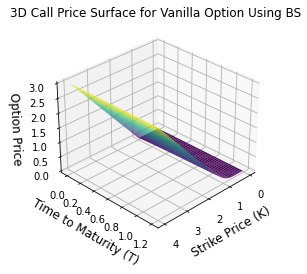

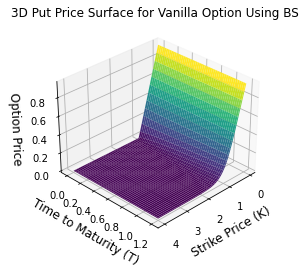

In [3]:
def PriceSurface_BS_C():
    # Define the range of maturity (T) and strike (K) values
    T_range = np.linspace(0.00001, 1.2, 100) 
    K_range = np.linspace(0.05, 4, 100)
    # Create a grid of T and K values
    T, K = np.meshgrid(T_range, K_range)
    # Calculate the option prices for each combination of T and K
    prices = np.zeros_like(T)
    for i in range(len(K_range)):
        for j in range(len(T_range)):
            prices[i, j] = BS_Call_Option_Price('c',S_0,K[i,j],sigma,T[i,j],r)
    
    paths = {"prices":prices,"T":T,"K":K}
    return paths

def PriceSurface_BS_P():
    # Define the range of maturity (T) and strike (K) values
    T_range = np.linspace(0.00001, 1.2, 100) 
    K_range = np.linspace(0.05, 4, 100)
    # Create a grid of T and K values
    T, K = np.meshgrid(T_range, K_range)
    # Calculate the option prices for each combination of T and K
    prices = np.zeros_like(T)
    for i in range(len(K_range)):
        for j in range(len(T_range)):
            prices[i, j] =BS_Call_Option_Price('p',S_0,K[i,j],sigma,T[i,j],r)

    paths = {"prices":prices,"T":T,"K":K}
    return paths


def Value_option_BS (T1T,K1K,T1,K1,A):
    option_price = griddata((T1T.flatten(), K1K.flatten()), A.flatten(), (T1, K1), method='linear')  # or cubic
    return option_price


p_C=PriceSurface_BS_C()
p_P=PriceSurface_BS_P()

K1K=p_C["K"]
T1T=p_C["T"]

prices_C=p_C["prices"]
prices_P=p_P["prices"]


#For Call

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K1K, T1T, prices_C, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price (K)', fontsize=12)
ax.set_ylabel('Time to Maturity (T)', fontsize=12)
ax.set_zlabel('Option Price', fontsize=12)
ax.set_title('3D Call Price Surface for Vanilla Option Using BS')

# Adjust viewing angle
ax.view_init(elev=30, azim=45)

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()


# For Put

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K1K, T1T, prices_P, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price (K)', fontsize=12)
ax.set_ylabel('Time to Maturity (T)', fontsize=12)
ax.set_zlabel('Option Price', fontsize=12)
ax.set_title('3D Put Price Surface for Vanilla Option Using BS')

# Adjust viewing angle
ax.view_init(elev=30, azim=45)

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()

In [8]:
def CallPutOptionPriceCOSMthd_BS(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])

    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0)

    x0 = np.log(S0 / K)

    # truncation domain   "Flexible way to define a and b"
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a);

    # Determine coefficients for Put Prices
    H_k = CallPutCoefficients_BS(CP,a,b,k)

    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]    # On doit diviser le premier element par 2

    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))

    return value

"""
Determine coefficients for Put Prices
"""
def CallPutCoefficients_BS(CP,a,b,k):
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        c = 0.0
        d = b
        coef = Chi_Psi_BS(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)

    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi_BS(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)

    return H_k

def Chi_Psi_BS(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c

    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0))
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi *
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)

    value = {"chi":chi,"psi":psi }
    return value

In [42]:
def GeneratePathsMckeanEulerBS_Sorted(j,NoOfPaths,NoOfSteps,T,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S1_H):
    np.random.seed(j)

    E1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    E2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])

    ZC = np.zeros([L, NoOfSteps])

    V = np.zeros([NoOfPaths, NoOfSteps+1])
    SC = np.zeros([NoOfPaths, NoOfSteps+1])

    V[:,0]=v0_Y
    SC[:,0]=S_0

    dt = T / float(NoOfSteps)

    E1[:,0] = (E1[:,0] - np.mean(E1[:,0])) / np.std(E1[:,0])
    E2[:,0] = (E2[:,0] - np.mean(E2[:,0])) / np.std(E2[:,0])

    V[:,1] = V[:,0] + kappa_Y*(vbar_Y - V[:,0]) * dt + gamma_Y* np.sqrt(V[:,0]) * np.power(dt, 0.5)*E1[:,0]
    V[:,1] = np.maximum(V[:,1],0.0)

    SC[:,1] = S1_H[:,1]
    SC[:,1] = np.maximum(SC[:,1],0.0)

#     time[1]=dt

    for i in range(1,NoOfSteps):
        print(i)
        if NoOfPaths > 1:
            E1[:,i] = (E1[:,i] - np.mean(E1[:,i])) / np.std(E1[:,i])
            E2[:,i] = (E2[:,i] - np.mean(E2[:,i])) / np.std(E2[:,i])


#  Sigma Dupire

        t=i*dt
        Sig_Dp_C=(Sigma_Dup_BS('c',t,SC[:,i])).reshape(-1,)

#  Expectation

        SSC= np.zeros([NoOfPaths, 1])

        AC=sorted(SC[:,i])

        for l in range(1, L+1):
            ZC[l-1,i] = AC[int((l*NoOfPaths)/(L+1))]

        SSC[:,0]=np.abs(Expectation(NoOfPaths,Lambda,L,ZC[:,i],SC[:,i],V[:,i]))

        V[:,i+1] = V[:,i] + kappa_Y*(vbar_Y - V[:,i]) * dt + gamma_Y * np.sqrt(V[:,i]) * np.power(dt, 0.5)*E1[:,i]
        V[:,i+1] = np.maximum(V[:,i+1],0.0)

        SC[:,i+1] = SC[:,i] + SC[:,i]  * np.sqrt(V[:,i]) * (np.sqrt(Sig_Dp_C) /  np.sqrt(SSC[:,0])) * np.power(dt, 0.5)*E2[:,i]
        SC[:,i+1] = np.maximum(SC[:,i+1],0.0)



        inf_indices = np.where(np.isinf(SC[:, i+1]))[0]
        SC[inf_indices,i+1] = 0

        inf_indices0 = np.where(np.isnan(SC[:, i+1]))[0]
        SC[inf_indices0,i+1] = 0


    paths = {"SC":SC}
    return paths

In [43]:
# random_list = random.sample(range(1, 10001), 1)
Random_Seed=14
T1=4

In [48]:
N0=500
Repetation_nbre=100

B500=np.zeros([N0, Repetation_nbre])

Paths_BS500 = GeneratePathsGBMABM(N0,M,T1,r,sigma,S_0)
S500_BS = Paths_BS500["S"]


random_list = random.sample(range(1, 10000), np.shape(B500)[1])

for t,j in enumerate(random_list):

    Paths_Mckean500= GeneratePathsMckeanEulerBS_Sorted(755,N0,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S500_BS)
    BS500 = Paths_Mckean500["SC"]
    B500[:,t] = BS500[:,-1]

In [38]:
N1=1000
Repetation_nbre2=20

B1000=np.zeros([N1, Repetation_nbre2])

Paths_BS1000 = GeneratePathsGBMABM(N1,M,T1,r,sigma,S_0)
S1000_BS = Paths_BS1000["S"]


random_list = random.sample(range(1, 10000), np.shape(B1000)[1])

for t,j in enumerate(random_list):
    print(t)
    print(j)
    Paths_Mckean1000= GeneratePathsMckeanEulerBS_Sorted(j,N1,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S1000_BS)
    BS1000 = Paths_Mckean1000["SC"]
    B1000[:,t] = BS1000[:,-1]


0
7476
1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
3
4083
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
7
9981
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
2

150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399


303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
16
4722
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


In [39]:
N2=2000

Paths_BS2000 = GeneratePathsGBMABM(N2,M,T1,r,sigma,S_0)
S2000_BS = Paths_BS2000["S"]

Paths_Mckean2000= GeneratePathsMckeanEulerBS_Sorted(Random_Seed,N2,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S2000_BS)
BS2000 = Paths_Mckean2000["SC"]

indices_non_nuls1 = np.nonzero(BS2000[:, -1])[0]
TBS2000 = np.array([BS2000[i, -1] for i in indices_non_nuls1])
print(np.shape(TBS2000))

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [40]:
N3000=3000

Paths_BS3000 = GeneratePathsGBMABM(N3000,M,T1,r,sigma,S_0)
S3000_BS = Paths_BS3000["S"]

Paths_Mckean3000= GeneratePathsMckeanEulerBS_Sorted(Random_Seed,N3000,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S3000_BS)
BS3000 = Paths_Mckean3000["SC"]

indices_non_nuls1 = np.nonzero(BS3000[:, -1])[0]
TBS3000 = np.array([BS3000[i, -1] for i in indices_non_nuls1])
print(np.shape(TBS3000))

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [41]:
N3=5000

Paths_BS5000 = GeneratePathsGBMABM(N3,M,T1,r,sigma,S_0)
S5000_BS = Paths_BS5000["S"]


Paths_Mckean5000= GeneratePathsMckeanEulerBS_Sorted(Random_Seed,N3,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S5000_BS)
BS5000 = Paths_Mckean5000["SC"]

indices_non_nuls1 = np.nonzero(BS5000[:, -1])[0]
TBS5000 = np.array([BS5000[i, -1] for i in indices_non_nuls1])
print(np.shape(TBS5000))

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [42]:
N4=10000

Paths_BS10000 = GeneratePathsGBMABM(N4,M,T1,r,sigma,S_0)
S10000_BS = Paths_BS10000["S"]


Paths_Mckean10000= GeneratePathsMckeanEulerBS_Sorted(Random_Seed,N4,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S10000_BS)
BS10000 = Paths_Mckean10000["SC"]

indices_non_nuls1 = np.nonzero(BS10000[:, -1])[0]
TBS10000 = np.array([BS10000[i, -1] for i in indices_non_nuls1])
print(np.shape(TBS10000))

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
(9996,)


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


Error Mckean with 500 paths 0.022961343266653764
Error Mckean with 1000 paths 0.011581473142378253
Error Mckean with 2000 paths 0.007626323356375215
Error Mckean with 3000 paths 0.00464080040767252
Error Mckean with 5000 paths 0.004474332996664825
Error Mckean with 10000 paths 0.0014451141125041882
C=0.423
Formula C/np.sqrt(Nbre of paths)
Error With formula for 500 paths  0.01891713508964822
Error With formula for 1000 paths  0.013376434502512245
Error With formula for 2000 paths 0.00945856754482411
Error With formula for 1000 paths  0.007722888060822841
Error With formula for 5000 paths 0.0059821233688381915
Error With formula for 10000 paths 0.00423


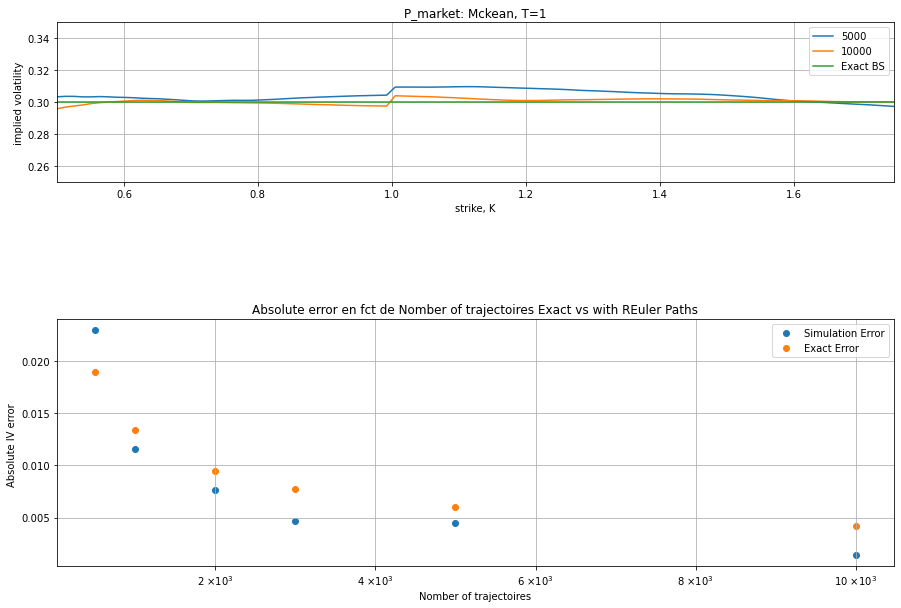

In [50]:
def mainCalculation():

    plt.figure(figsize=(15,10))
    T=1

    plt.subplot(3, 1, 1)

    K1 = np.linspace(0.5,1.75,100)
    K1 = np.array(K1).reshape([len(K1),1])

    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.5,1.75))
    plt.ylim((0.25,0.35))
    plt.title("P_market: Mckean, T=1")
    legend = []

    L=[500,1000,2000,3000,5000,10000]
    

    LL0500 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:

            L0=[]
            for j in range(np.shape(B500)[1]):

                indices = np.nonzero(B500[:, j])[0]
                ST500 = np.array([B500[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST500,0))
                L0.append(V_market_Mckean1_P)

            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'p',T,r)

        else:

            L0=[]
            for j in range(np.shape(B500)[1]):

                indices = np.nonzero(B500[:, j])[0]
                ST500 = np.array([B500[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(ST500-K1[idx],0))
                L0.append(V_market_Mckean1_P)

            A=sum(L0)/len(L0)
            LL0500[idx] = ImpliedVolatility(A,K1[idx],'c',T,r)
            


    LL01000 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:

            L1=[]
            for j in range(np.shape(B1000)[1]):

                indices = np.nonzero(B1000[:, j])[0]
                ST1000 = np.array([B1000[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST1000,0))
                L1.append(V_market_Mckean1_P)

            A=sum(L1)/len(L1)
            LL01000[idx] = ImpliedVolatility(A,K1[idx],'p',T,r)

        else:

            L1=[]
            for j in range(np.shape(B1000)[1]):

                indices = np.nonzero(B1000[:, j])[0]
                ST1000 = np.array([B1000[i, j] for i in indices])

                V_market_Mckean1_P=np.mean(np.maximum(ST1000-K1[idx],0))
                L1.append(V_market_Mckean1_P)

            A=sum(L1)/len(L1)
            LL01000[idx] = ImpliedVolatility(A,K1[idx],'c',T,r)



    LL02000 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-TBS2000,0))
            LL02000[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
        else:
            V_market_Mckean1_C = np.mean(np.maximum(TBS2000-K1[idx],0))
            LL02000[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    LL03000 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-TBS3000,0))
            LL03000[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
        else:
            V_market_Mckean1_C = np.mean(np.maximum(TBS3000-K1[idx],0))
            LL03000[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)




    LL50 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-TBS5000,0))
            LL50[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
        else:
            V_market_Mckean1_C = np.mean(np.maximum(TBS5000-K1[idx],0))
            LL50[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
    plt.plot(K1,LL50)
    legend.append('{0}'.format("5000"))



    LL010 =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-TBS10000,0))
            LL010[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
        else:
            V_market_Mckean1_C = np.mean(np.maximum(TBS10000-K1[idx],0))
            LL010[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)

    plt.plot(K1,LL010)
    legend.append('{0}'.format("10000"))


    # LL20 =np.zeros([len(K1),1])
    # for idx in range(0,len(K1)):
    #   if K1[idx]< S_0:
    #     V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-S2_P_BS[:,-1],0))
    #     LL20[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
    #   else:
    #     V_market_Mckean1_C = np.mean(np.maximum(S2BS[:,-1]-K1[idx],0))
    #     LL20[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)

    # plt.plot(K1,LL20)
    # legend.append('{0}'.format("20000"))


    L_BS =np.zeros([len(K1),1])
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H1P = BS_Call_Option_Price('p',K1[idx],S_0,sigma,T,r)
            L_BS[idx] = ImpliedVolatility(V_market_H1P,K1[idx],'p',T,r)
        else:
            V_market_H1C = BS_Call_Option_Price('c',K1[idx],S_0,sigma,T,r)
            L_BS[idx] = ImpliedVolatility(V_market_H1C,K1[idx],'c',T,r)

    plt.plot(K1,L_BS)
    legend.append('{0}'.format("Exact BS"))


    plt.legend(legend)

    L1=[np.mean(np.abs(LL0500-L_BS)),np.mean(np.abs(LL01000-L_BS)),np.mean(np.abs(LL02000-L_BS)),np.mean(np.abs(LL03000-L_BS))\
        ,np.mean(np.abs(LL50-L_BS)),np.mean(np.abs(LL010-L_BS))]



    print("Error Mckean with 500 paths",L1[0])
    print("Error Mckean with 1000 paths",L1[1])
    print("Error Mckean with 2000 paths",L1[2])
    print("Error Mckean with 3000 paths",L1[3])
    print("Error Mckean with 5000 paths",L1[4])
    print("Error Mckean with 10000 paths",L1[5])

    C = 0.423
    L2=[0.423/np.sqrt(i) for i in L]
    print("C=0.423")
    print("Formula C/np.sqrt(Nbre of paths)")
    print("Error With formula for 500 paths ",C/np.sqrt(500))
    print("Error With formula for 1000 paths ",C/np.sqrt(1000))
    print("Error With formula for 2000 paths",C/np.sqrt(2000))
    print("Error With formula for 1000 paths ",C/np.sqrt(3000))
    print("Error With formula for 5000 paths",C/np.sqrt(5000))
    print("Error With formula for 10000 paths",C/np.sqrt(10000))
    # print("Error With formula",C/np.sqrt(20000))
    # print("Error With formula",C/np.sqrt(30000))


    plt.subplot(2, 1, 2)
    plt.scatter(L,L1)
    plt.scatter(L,L2)

    plt.legend(['Simulation Error', 'Exact Error'])
    plt.grid()
    plt.xlabel("Nomber of trajectoires")
    plt.ylabel("Absolute IV error ")
    plt.title("Absolute error en fct de Nomber of trajectoires Exact vs with REuler Paths")
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.0f} {}".format(x/1000, r'$\times 10^{3}$')\
                                                             if x >= 1000 else "{:.0f} {}".format(x/100, r'$\times 10^{2}$')))




mainCalculation();

### Lamda Effect :

NB: to obtain the same result as in the article, set N1 = 1000000 and repeat the code 100 times.

In [9]:
Lamdaa=[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1]
N1=5000
T1=1
Repetation_nbre2= 10


B1000=np.zeros([N1, Repetation_nbre2 ,len(Lamdaa)])

Paths_BS1000 = GeneratePathsGBMABM(N1,M,T1,r,sigma,S_0)
S1000_BS = Paths_BS1000["S"]

# Rendom_seed=14
random_list = random.sample(range(1, 10000), np.shape(B1000)[1])

    
    
for t,j in enumerate(Lamdaa):
    print(t)
    for i1,i2 in enumerate(random_list):
        print(i1)
        Paths_Mckean1000= GeneratePathsMckeanEulerBS_Sorted(i2,N1,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda,S1000_BS)
        BS1000 = Paths_Mckean1000["SC"]
        B1000[:,i1,t] = BS1000[:,-1]  

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


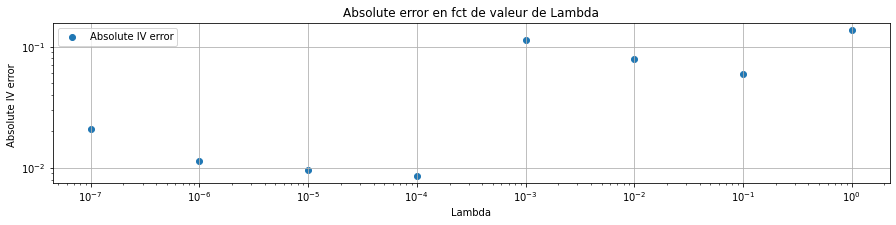

In [62]:
def mainCalculation():

    plt.figure(figsize=(15,10))
    T=1
    K=1
    plt.subplot(3, 1, 1)

    legend = []
        
    L0=[]
    L1=[]
    

    for j in range(len(Lamdaa)):

        indices = np.nonzero(B1000[:, j])[0]
        ST5000 = np.array([B1000[i, j] for i in indices])

        V_market_Mckean1_P=np.mean(np.maximum(ST5000-K,0))
        Imp = ImpliedVolatility(V_market_Mckean1_P,K,'c',T,r)
        L0.append(Imp)
            
        V_market_H1P = BS_Call_Option_Price('c',K,S_0,sigma,T,r)
        Imp2 = ImpliedVolatility(V_market_H1P,K,'c',T,r)
        L1.append(Imp2)

            
            
#     plt.legend(legend)

    LL=[]
    for i in range(len(L1)):
        a=np.abs(L1[i]-L0[i])
        LL.append(a)


    
    plt.scatter(Lamdaa, LL, label='Absolute IV error')

    plt.xscale('log')
    plt.yscale('log')


    plt.grid()
    plt.xlabel("Lambda")
    plt.ylabel("Absolute IV error ")
    plt.title("Absolute error en fct de valeur de Lambda")
    
    plt.legend()
    plt.show()


mainCalculation();

### L effect :

NB: to obtain the same result as in the article, set N1 = 1000000 and Repetation_nbre2=100

In [14]:
L_range=[2,7,10,15,20,25,30]
N1=1000
T1=1
Lambda=0.00001

Repetation_nbre2=10

LB5000=np.zeros([N1, Repetation_nbre2 ,len(L_range)])

LPaths_BS5000 = GeneratePathsGBMABM(N1,M,T1,r,sigma,S_0)
LS5000_BS = LPaths_BS5000["S"]

# Rendom_seed=14
random_list = random.sample(range(1, 10000), np.shape(LB5000)[1])

for t,j in enumerate(L_range):
    print(t)
    for i1,i2 in enumerate(random_list):
        Paths_Mckean5000= GeneratePathsMckeanEulerBS_Sorted(i2,N1,M,T1,r,S_0,kappa_Y,gamma_Y,vbar_Y,v0_Y,j,Lambda,LS5000_BS)
        LBS5000 = Paths_Mckean5000["SC"]
        LB5000[:,i1,t] = LBS5000[:,-1]

0
1
2


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423


337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439


351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289


201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450


361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply


380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157


59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
3

230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479


392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
3

242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491


402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
3

251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2


412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189


101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360


272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
3

433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371


283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221


133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382


293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
6

454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392


304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242


154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403


315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
****
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403

312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
****
16
17
18
19
20
21
****
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
****
79
80
81

466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243


151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400


305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
****
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75

464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
6
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
24

152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401


313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251


163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412


324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


In [ ]:
def mainCalculation():

    plt.figure(figsize=(15,10))
    T=1
    K=1
    plt.subplot(3, 1, 1)
    
    legend = []
        
    L0=[]
    L1=[]
    
    for j in range(0,len(L_range)):
        L2=[]
        for i in range(np.shape(LB5000)[1]):

            indices = np.nonzero(LB5000[:,i, j])[0]
            LST5000 = np.array([LB5000[a,i, j] for a in indices])

            V_market_Mckean1_P=np.mean(np.maximum(LST5000-K,0))
            L2.append(V_market_Mckean1_P)
            
        A=sum(L2)/len(L2)
        
        Imp1 = ImpliedVolatility(A,K,'c',T,r)
        
        L0.append(Imp1)
        
        
        V_market_H1P = BS_Call_Option_Price('c',K,S_0,sigma,T,r)
        Imp2 = ImpliedVolatility(V_market_H1P,K,'c',T,r)
        L1.append(Imp2)  
            
#     plt.legend(legend)

    LL=[]
    for i in range(len(L1)):
        a=np.abs(L1[i]-L0[i])
        LL.append(a)


    
    plt.scatter(L_range, LL, label='Absolute IV error')    
    
    plt.yscale('log')

    plt.grid()
    plt.xlabel("Number of basis functions: L")
    plt.ylabel("Absolute IV error ")
    plt.title("Absolute error en fct de valeur de L")
    
    plt.legend()
    plt.show()


mainCalculation();

# Calibration avec Heston et surface de prix

In [5]:
def PriceSurface_Heston_C_Ex():
    CP    = OptionType.CALL
    # Define the range of maturity (T) and strike (K) values
    T_range = np.linspace(0.001, 2, 300) 
    K_range = np.linspace(0.001, 8, 300)
    # Create a grid of T and K values
    T, K = np.meshgrid(T_range, K_range)
    # Calculate the option prices for each combination of T and K
    prices = np.zeros_like(T)
    for j in range(len(T_range)):
        cf = ChFHestonModel(r,T[0,j],kappa,gamma,vbar,v0,rho)
        prices[:,j] = (CallPutOptionPriceCOSMthd(cf, CP , S_0, r, T[0,j], K_range , 1000, 8)).reshape(-1,)
    
    paths = {"prices":prices,"T":T,"K":K}
    return paths

p_H1_C=PriceSurface_Heston_C_Ex()

prices_H1_C=p_H1_C["prices"]
H1T=p_H1_C["T"]
H1K=p_H1_C["K"]

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [4]:
def PriceSurface_Heston_P_Ex():
    CP    = OptionType.PUT
    # Define the range of maturity (T) and strike (K) values
    T_range = np.linspace(0.01, 2, 300) 
    K_range = np.linspace(0.01, 8, 300)
    # Create a grid of T and K values
    T, K = np.meshgrid(T_range, K_range)
    # Calculate the option prices for each combination of T and K
    prices = np.zeros_like(T)
    for j in range(len(T_range)):
        cf = ChFHestonModel(r,T[0,j],kappa,gamma,vbar,v0,rho)
        prices[:,j] = (CallPutOptionPriceCOSMthd(cf, CP , S_0, r, T[0,j], K_range , 1000, 8)).reshape(-1,)
    
    paths = {"prices":prices,"T":T,"K":K}
    return paths

p_H1_P=PriceSurface_Heston_P_Ex()
prices_H1_P=p_H1_P["prices"]

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [6]:
def Value_option_Heston(H1T,H1K,T1,K1,A):
    option_price = griddata((H1T.flatten(), H1K.flatten()), A.flatten(), (T1, K1), method='linear')
    return option_price

In [20]:
T1=0.5
K1=0.9
Value_option_Heston(H1T,H1K,T1,K1,prices_H1_C)

array(0.14060864)

In [5]:
T1=0.5
K1=0.9
Paths_H = GeneratePathsHestonEuler(10000,1000,T1,r,S_0,kappa,gamma,rho,vbar,v0)
S=Paths_H['S']
np.mean(np.maximum(S[:,-1]-K1,0))

0.14082821478647836

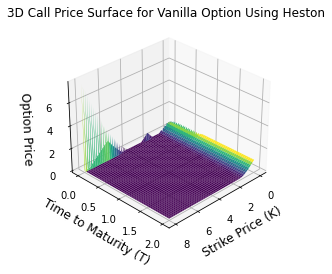

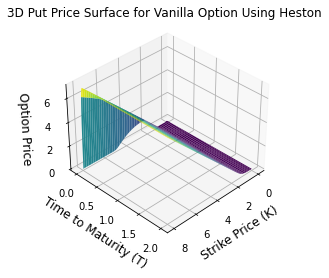

In [7]:
# Call case

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(H1K, H1T, prices_H1_C, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price (K)', fontsize=12)
ax.set_ylabel('Time to Maturity (T)', fontsize=12)
ax.set_zlabel('Option Price', fontsize=12)
ax.set_title('3D Call Price Surface for Vanilla Option Using Heston')

# Adjust viewing angle
ax.view_init(elev=30, azim=45)

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()


# Put case

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(H1K, H1T, prices_H1_P, cmap='viridis')

# Set labels and title
ax.set_xlabel('Strike Price (K)', fontsize=12)
ax.set_ylabel('Time to Maturity (T)', fontsize=12)
ax.set_zlabel('Option Price', fontsize=12)
ax.set_title('3D Put Price Surface for Vanilla Option Using Heston')

# Adjust viewing angle
ax.view_init(elev=35, azim=45)

# Add grid lines
ax.grid(True)

# Show the plot
plt.show()

# Verification between the COS method and Euler discretization for Heston calibration

In [35]:
import enum 
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))     
    return value

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

# Determine coefficients for Put Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)                  
    return H_k    

def ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rho):
    i = np.complex(0.0,1.0)
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r * i*u *tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    # Characteristic function for the Heston's model    
    cf = lambda u: np.exp(A(u) + C(u)*v0)
    return cf 

In [6]:
NoOfPaths1 = 10000
T=1
Paths_He =  GeneratePathsHestonEuler(NoOfPaths1,1000,T,r,S_0,kappa,gamma,rho,vbar,v0)
S1_He = Paths_He["S"]

In [7]:
K=1
print(np.mean(np.maximum(S1_He[:,-1]-K,0)))

cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
print(CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K] , 1000, 8)[0,0])

0.0979625420623615


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.09794216659373037


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

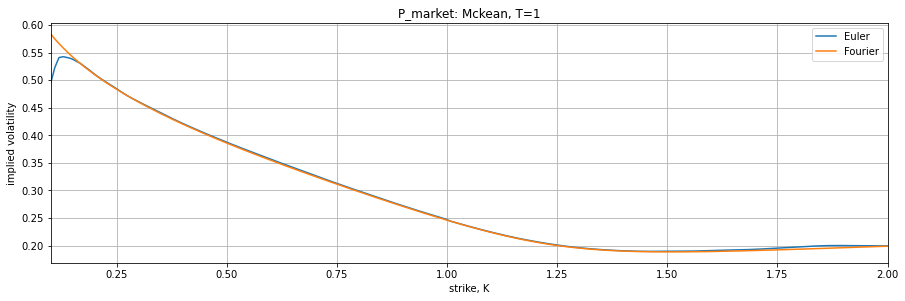

In [9]:
def mainCalculation(): 
    T=1
    plt.figure(figsize=(15,15))
    
    plt.subplot(3, 1, 1)
    
    K1 = np.linspace(0.2,2,200)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.1,2)) 
#     plt.ylim((0.0,0.5))
    plt.title("P_market: Mckean, T=1")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-S1_He[:,-1],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(S1_He[:,-1]-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Euler"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,1,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Fourier"))

    
    plt.legend(legend)
    
    
mainCalculation();

# Principal code for Heston

In [36]:
def GeneratePathsMckeanEuler(j,NoOfPaths,NoOfSteps,kappa,gamma,vbar,v0,rho,T,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y):   
    np.random.seed(j)

    E1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    E2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    
    ZC = np.zeros([L, NoOfSteps])
    
#     time = np.zeros([NoOfSteps+1])
    
    V = np.zeros([NoOfPaths, NoOfSteps+1])
    SC = np.zeros([NoOfPaths, NoOfSteps+1]) 
    
    V[:,0]=v0_Y 
    SC[:,0]=S_0
    
    dt = T / float(NoOfSteps)
    
    E1[:,0] = (E1[:,0] - np.mean(E1[:,0])) / np.std(E1[:,0])
    E2[:,0] = (E2[:,0] - np.mean(E2[:,0])) / np.std(E2[:,0]) 

    V[:,1] = V[:,0] + kappa_Y*(vbar_Y - V[:,0]) * dt + gamma_Y* np.sqrt(V[:,0]) * np.power(dt, 0.5)*E1[:,0]
    V[:,1] = np.maximum(V[:,1],0.0)
    
    SC[:,1] = S1_H[:,1]
    SC[:,1] = np.maximum(SC[:,1],0.0)


#     time[1]=dt
    
    for i in range(1,NoOfSteps):
        print(i)
        if NoOfPaths > 1:
            E1[:,i] = (E1[:,i] - np.mean(E1[:,i])) / np.std(E1[:,i])
            E2[:,i] = (E2[:,i] - np.mean(E2[:,i])) / np.std(E2[:,i])

            
#  Sigma Dupire

        t=i*dt
        Sig_Dp_C=(Sigma_Dup_H(OptionType.CALL,r,S_0,t,SC[:,i],kappa,gamma,vbar,v0,rho)).reshape(-1,)

#  Expectation
        
        SSC= np.zeros([NoOfPaths, 1])
        SSP= np.zeros([NoOfPaths, 1])
        
        AC=sorted(SC[:,i])
        
        for l in range(1, L+1):
            ZC[l-1,i] = AC[int((l*NoOfPaths)/(L+1))]
 
        SSC[:,0]=np.abs(Expectation(NoOfPaths,Lambda,L,ZC[:,i],SC[:,i],V[:,i]))
        
        V[:,i+1] = V[:,i] + kappa_Y*(vbar_Y - V[:,i]) * dt + gamma_Y* np.sqrt(V[:,i]) * np.power(dt, 0.5)*E1[:,i]
        V[:,i+1] = np.maximum(V[:,i+1],0.0)

        
        SC[:,i+1] = SC[:,i] + SC[:,i]  * np.sqrt(V[:,i]) * (Sig_Dp_C /  np.sqrt(SSC[:,0])) * np.power(dt, 0.5)*E2[:,i]       
        SC[:,i+1] = np.maximum(SC[:,i+1],0.0)

            
        inf_indices = np.where(np.isinf(SC[:, i+1]))[0]
        SC[inf_indices,i+1] = 0

        inf_indices0 = np.where(np.isnan(SC[:, i+1]))[0]
        SC[inf_indices0,i+1] = 0

        
#         time[i+1] = time[i] +dt
    
    paths = {"SC":SC}
    return paths



# T=1

In [8]:
NoOfPaths1 = 10000
T1=1
Random_seed=14

Paths_H =  GeneratePathsHestonEuler(NoOfPaths1,M,T1,r,S_0,kappa,gamma,rho,vbar,v0)
S1_H = Paths_H["S"]

In [9]:
Paths_Mckean = GeneratePathsMckeanEuler(Random_seed,NoOfPaths1,M,kappa,gamma,vbar,v0,rho,T1,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y)
S1 = Paths_Mckean["SC"]

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [10]:
print(np.shape(S1[:,-1]))
indices_non_nuls1 = np.nonzero(S1[:, -1])[0]
ST1 = np.array([S1[i, -1] for i in indices_non_nuls1])
print(np.shape(ST1))

(10000,)
(10000,)


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the nump

Mckean Paths 0.002451167898015815
C=0.272
Formula C/np.sqrt(Nbre of paths)
Error With formula  0.00272


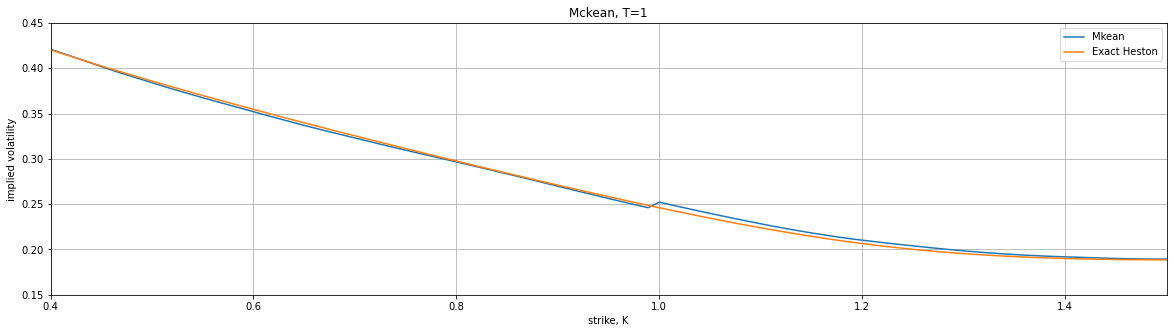

In [11]:
def mainCalculation(): 
    T=1
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 1, 1)
    
    K1 = np.linspace(0.4,1.5,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.4,1.5)) 
    plt.ylim((0.15,0.45))
    plt.title("Mckean, T=1")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST1,0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(ST1-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact Heston"))


    
    print("Mckean Paths",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    C = 0.272
    print("C=0.272")
    print("Formula C/np.sqrt(Nbre of paths)")
    print("Error With formula ",C/np.sqrt(NoOfPaths1))
    
mainCalculation();

## very far in-the-money or out-of-the-money options

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

Mckean error 0.0030369271584581923
C=0.272
Formula C/np.sqrt(Nbre of paths)
Error With formula  0.00272


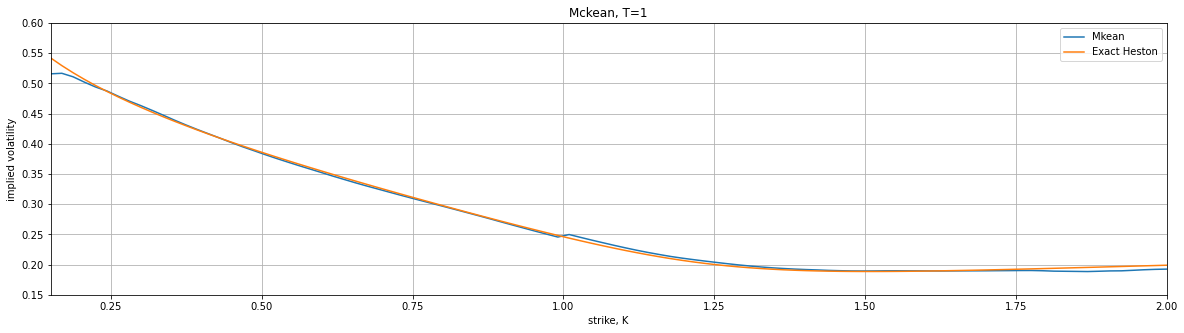

In [25]:
def mainCalculation(): 
    T=1
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 1, 1)
    
    K1 = np.linspace(0.15,2,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.15,2)) 
    plt.ylim((0.15,0.6))
    plt.title("Mckean, T=1")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST1,0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(ST1-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact Heston"))

    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    C = 0.272
    print("C=0.272")
    print("Formula C/np.sqrt(Nbre of paths)")
    print("Error With formula ",C/np.sqrt(NoOfPaths1))
    
mainCalculation();

## Solution:

In [14]:
def GeneratePathsMckeanEuler_Solution(j,NoOfPaths,NoOfSteps,kappa,gamma,vbar,v0,rho,T,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda):
    np.random.seed(j)

    E1 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    E2 = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])

    ZC = np.zeros([50, NoOfSteps])

#     time = np.zeros([NoOfSteps+1])

    V = np.zeros([NoOfPaths, NoOfSteps+1])
    SC = np.zeros([NoOfPaths, NoOfSteps+1])

    V[:,0]=v0_Y
    SC[:,0]=S_0

    dt = T / float(NoOfSteps)

    E1[:,0] = (E1[:,0] - np.mean(E1[:,0])) / np.std(E1[:,0])
    E2[:,0] = (E2[:,0] - np.mean(E2[:,0])) / np.std(E2[:,0])

    V[:,1] = V[:,0] + kappa_Y*(vbar_Y - V[:,0]) * dt + gamma_Y* np.sqrt(V[:,0]) * np.power(dt, 0.5)*E1[:,0]
    V[:,1] = np.maximum(V[:,1],0.0)

    SC[:,1] = S1_H[:,1]
    SC[:,1] = np.maximum(SC[:,1],0.0)


#     time[1]=dt

    for i in range(1,NoOfSteps):
        print(i)
        if NoOfPaths > 1:
            E1[:,i] = (E1[:,i] - np.mean(E1[:,i])) / np.std(E1[:,i])
            E2[:,i] = (E2[:,i] - np.mean(E2[:,i])) / np.std(E2[:,i])


#  Sigma Dupire

        t=i*dt
        Sig_Dp_C=(Sigma_Dup_H(OptionType.CALL,r,S_0,t,SC[:,i],kappa,gamma,vbar,v0,rho)).reshape(-1,)

#  Expectation

        SSC= np.zeros([NoOfPaths, 1])

        AC=sorted(SC[:,i])

        for l in range(1, 6):
            ZC[l-1,i] = AC[int(0.001*l*NoOfPaths)]

        for l in range(1, L+1):
            ZC[4+l,i] = AC[int((l*NoOfPaths)/(L+1))]

        for l in range(1, 6):
            ZC[L+4+l,i] = AC[int((1-0.001*l)*NoOfPaths)]


        SSC[:,0]=np.abs(Expectation(NoOfPaths,Lambda,50,ZC[:,i],SC[:,i],V[:,i]))

        V[:,i+1] = V[:,i] + kappa_Y*(vbar_Y - V[:,i]) * dt + gamma_Y* np.sqrt(V[:,i]) * np.power(dt, 0.5)*E1[:,i]
        V[:,i+1] = np.maximum(V[:,i+1],0.0)


        SC[:,i+1] = SC[:,i] + SC[:,i]  * np.sqrt(V[:,i]) * (Sig_Dp_C /  np.sqrt(SSC[:,0])) * np.power(dt, 0.5)*E2[:,i]
        SC[:,i+1] = np.maximum(SC[:,i+1],0.0)




        inf_indices = np.where(np.isinf(SC[:, i+1]))[0]
        SC[inf_indices,i+1] = 0

        inf_indices0 = np.where(np.isnan(SC[:, i+1]))[0]
        SC[inf_indices0,i+1] = 0


    paths = {"SC":SC}
    return paths



In [14]:
Paths_Mckean =GeneratePathsMckeanEuler_Solution(Random_seed,NoOfPaths1,M,kappa,gamma,vbar,v0,rho,T1,r,S_0,S1_H,kappa_Y,gamma_Y,vbar_Y,v0_Y,L,Lambda)
S1_Deep = Paths_Mckean["SC"]

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [15]:
print(np.shape(S1_Deep[:,-1]))
indices_non_nuls10 = np.nonzero(S1_Deep[:, -1])[0]
ST1_Deep = np.array([S1_Deep[i, -1] for i in indices_non_nuls10])
print(np.shape(ST1_Deep))

(10000,)
(10000,)


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

Mckean error 0.0025060795447451652


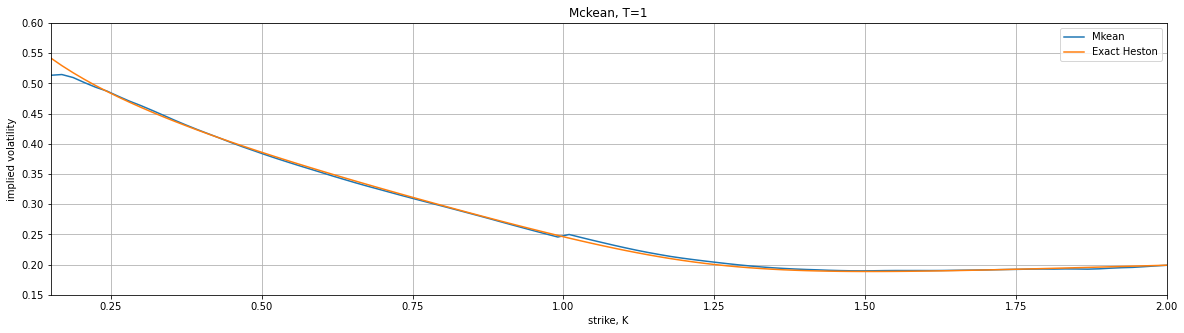

In [24]:
def mainCalculation(): 
    T=1
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 1, 1)
    
    K1 = np.linspace(0.15,2,100)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.15,2)) 
    plt.ylim((0.15,0.6))
    plt.title("Mckean, T=1")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST1_Deep,0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(ST1_Deep-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact Heston"))

    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    
mainCalculation();

# T=4

In [24]:
NoOfPaths1 = 10000
T4=4

Paths_H4 =  GeneratePathsHestonEuler(NoOfPaths1,M,T4,r,S_0,kappa,gamma,rho,vbar,v0)
S4_H = Paths_H4["S"]

Paths_Mckean4 = GeneratePathsMckeanEuler(755,NoOfPaths1,M,kappa,gamma,vbar,v0,rho,T4,r,S_0,S4_H,kappa_Y,gamma_Y,vbar_Y,v0_Y)
S4 = Paths_Mckean4["SC"]

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


202


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


487
488
489
490
491
492
493
494
495
496
497
498
499


In [25]:
print(np.shape(S4[:,-1]))
indices_non_nuls4 = np.nonzero(S4[:, -1])[0]
ST4 = np.array([S4[i, -1] for i in indices_non_nuls4])
print(np.shape(ST4))

(10000,)
(9977,)


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

Mckean error 0.0014548289958258049


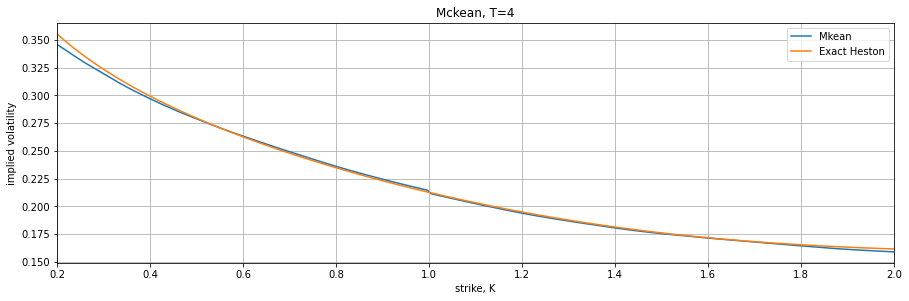

In [37]:
def mainCalculation(): 

    plt.figure(figsize=(15,15))
    
    plt.subplot(3, 1, 1)
    
    K1 = np.linspace(0.2,2,200)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.2,2)) 
#     plt.ylim((0.0,0.5))
    plt.title("Mckean, T=4")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST4,0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T4,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(ST4-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T4,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T4,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T4, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T4,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T4, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T4,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact Heston"))


    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    
mainCalculation();

### Let's Price our options "CALL & PUT" after assuring the matching of the Imp Vol

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Mckean error 0.0010857681390310295


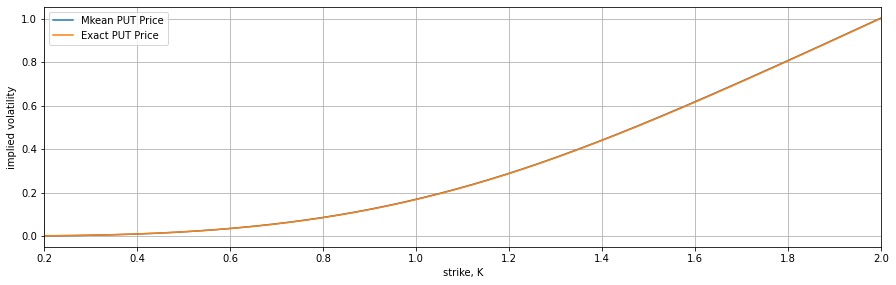

In [43]:
def mainCalculation(): 

    plt.figure(figsize=(15,15))
    
    plt.subplot(3, 1, 1)
    
    K1 = np.linspace(0.2,2,200)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.2,2)) 
#     plt.title("Mckean, T=4")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        LL1[idx]=np.mean(np.maximum(K1[idx]-ST4,0))
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean PUT Price"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T4,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        L_H[idx]=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T4, [K1[idx]] , 1000, 8)[0,0]
    
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact PUT Price"))


    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    
mainCalculation();

C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Mckean error 0.00094629427293346


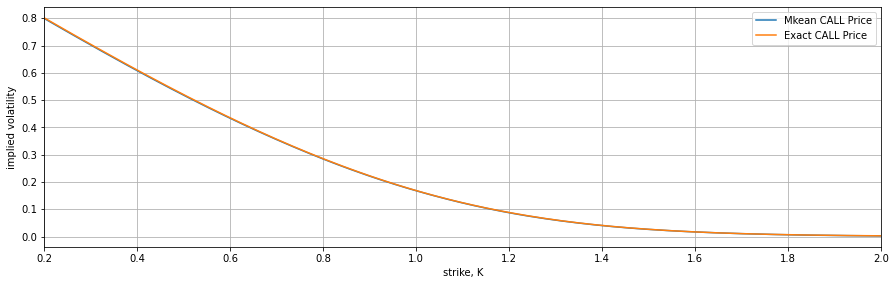

In [44]:
def mainCalculation(): 

    plt.figure(figsize=(15,15))
    
    plt.subplot(3, 1, 1)
    
    K1 = np.linspace(0.2,2,200)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.2,2)) 
#     plt.title("Mckean, T=4")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        LL1[idx]=np.mean(np.maximum(ST4-K1[idx],0))
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean CALL Price"))  
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T4,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        L_H[idx]=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T4, [K1[idx]] , 1000, 8)[0,0]
    
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact CALL Price"))


    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    
mainCalculation();

# T=10

In [52]:
NoOfPaths1 = 20000
T10=10
Random_seed=14

Paths_H10 =  GeneratePathsHestonEuler(NoOfPaths1,M,T10,r,S_0,kappa,gamma,rho,vbar,v0)
S10_H = Paths_H10["S"]

Paths_Mckean10 = GeneratePathsMckeanEuler(Random_seed,NoOfPaths1,M,kappa,gamma,vbar,v0,rho,T10,r,S_0,S10_H,kappa_Y,gamma_Y,vbar_Y,v0_Y)
S10 = Paths_Mckean10["SC"]

1


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


56


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Jihed\Anaconda3\lib\site-packages\numpy\core\numeric.py:936: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in multiply


497
498
499


In [53]:
print(np.shape(S10[:,-1]))
indices_non_nuls10 = np.nonzero(S10[:, -1])[0]
ST10 = np.array([S10[i, -1] for i in indices_non_nuls10])
print(np.shape(ST10))

(20000,)
(19507,)


C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\Jihed\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

Mckean error 0.016847772298236325


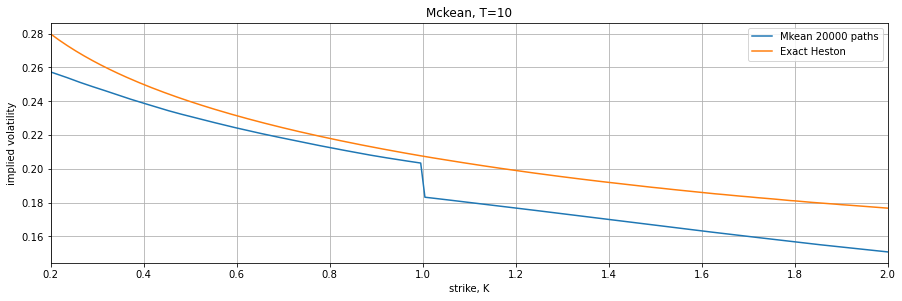

In [63]:
def mainCalculation(): 
    T=10
    plt.figure(figsize=(15,15))
    
    plt.subplot(3, 1, 1)
    
    K1 = np.linspace(0.2,2,200)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    plt.xlim((0.2,2)) 
#     plt.ylim((0.0,0.5))
    plt.title("Mckean, T=10")
    legend = []


    LL1 =np.zeros([len(K1),1])      
    for idx in range(0,len(K1)):
        if K1[idx] < S_0:
            V_market_Mckean1_P=np.mean(np.maximum(K1[idx]-ST10,0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_P,K1[idx],'p',T,r)
            
        else:   
            V_market_Mckean1_C=np.mean(np.maximum(ST10-K1[idx],0))
            LL1[idx] = ImpliedVolatility(V_market_Mckean1_C,K1[idx],'c',T,r)
            
    plt.plot(K1,LL1)
    legend.append('{0}'.format("Mkean 20000 paths")) 
         
          
     
    L_H =np.zeros([len(K1),1])
    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)
    for idx in range(0,len(K1)):
        if K1[idx]< S_0:
            V_market_H0=CallPutOptionPriceCOSMthd(cf, OptionType.PUT , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H0,K1[idx],'p',T,r)
        else:
            V_market_H1=CallPutOptionPriceCOSMthd(cf, OptionType.CALL , S_0, r, T, [K1[idx]] , 1000, 8)[0,0]
            L_H[idx] = ImpliedVolatility(V_market_H1,K1[idx],'c',T,r)
        
    plt.plot(K1,L_H)
    legend.append('{0}'.format("Exact Heston"))


    
    print("Mckean error",np.mean(np.abs(LL1-L_H)))

    
    plt.legend(legend)
    
    
mainCalculation();